<a id="title"></a>
# Calculating WFC3 Zeropoints with STSynphot
<hr>

## Learning Goals 
By the end of this tutorial, you will:
- Calculate zeropoints and other photometric properties using `stsynphot`.
- Create, plot, and save 'total system throughput' tables.

## Table of Contents
[Introduction](#intro) <br>
[1. Imports](#imports) <br>
[2. Download throughput tables and define variables](#envvar) <br>
[3. Set up the 'obsmode' string](#inps) <br>
[4. Basic usage for a single 'obsmode'](#usage) <br>
[5. Compute zeropoints and other photometric properties](#zps) <br>
[6. Iterate over multiple 'obsmodes'](#iterate) <br>
[7. Create and plot 'total system throughput' tables](#curves) <br>
[8. Conclusions](#conclusions) <br>
[Additional Resources](#resources) <br>
[About the Notebook](#about) <br>
[Citations](#cite) <br>

<a id="intro"></a>
## Introduction
This notebook shows how to calculate photometric zeropoints using the Python package `stsynphot` for any WFC3 detector, filter, date, or aperture. This tutorial is especially useful for calculating Vegamag zeropoints, which require an input spectrum. The notebook is also useful for computing time-dependent WFC3/UVIS zeropoints for any observation date, as the values listed in [WFC3 ISR 2021-04](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/WFC3_ISR_2021-04.pdf) are defined for the reference epoch. As of mid-2021, the WFC3/IR zeropoints are not time-dependent.

More documentation on `stsynphot` is available [here](https://stsynphot.readthedocs.io/en/latest/index.html). Using `stsynphot` requires downloading the throughput curves for the HST instruments and optical path.  One method of doing this is shown in [Section 2](#envvar).  More information on the throughput tables can be found [here](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/synphot-throughput-tables).

<a id="imports"></a>
## 1. Imports

This notebook assumes you have created the virtual environment in [WFC3 notebooks'](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/WFC3/README.md) installation instructions.

We import:
- *os* for setting environment variables
- *tarfile* for extracting a .tar archive

- *numpy* for handling array functions
- *matplotlib.pyplot* for plotting data
- *astropy* for astronomy related functions

- *synphot* and *stsynphot* for evaluating synthetic photometry

We will need to set the `PYSYN_CDBS` environment variable *before* importing stsynphot. We will also create a custom Vega spectrum, as the `stsynphot` will supercede the usual `synphot` functionality regarding the Vega spectrum and would otherwise require a downloaded copy of the spectrum to be provided.

In [1]:
import os
import tarfile

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table

from synphot import Observation

<a class="anchor" id="envvar"></a>
## 2. Download throughput tables and define variables

This section obtains the WFC3 throughput component tables for use with `stsynphot`. This step only needs to be done once. If these reference files have already been downloaded, this section can be skipped.

In [2]:
!curl -O https://archive.stsci.edu/hlsps/reference-atlases/hlsp_reference-atlases_hst_multi_everything_multi_v11_sed.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  1  796M    1 15.1M    0     0  39.2M      0  0:00:20 --:--:--  0:00:20 39.2M

 24  796M   24  191M    0     0   138M      0  0:00:05  0:00:01  0:00:04  138M

 35  796M   35  284M    0     0   119M      0  0:00:06  0:00:02  0:00:04  119M

 42  796M   42  341M    0     0   100M      0  0:00:07  0:00:03  0:00:04  100M

 49  796M   49  397M    0     0  90.5M      0  0:00:08  0:00:04  0:00:04 90.5M

 52  796M   52  415M    0     0  77.0M      0  0:00:10  0:00:05  0:00:05 79.9M

 54  796M   54  430M    0     0  67.4M      0  0:00:11  0:00:06  0:00:05 47.8M

 55  796M   55  444M    0     0  60.1M      0  0:00:13  0:00:07  0:00:06 32.0M

 58  796M   58  462M    0     0  55.1M      0  0:00:14  0:00:08  0:00:06 24.1M

 60  796M   60  484M    0     0  51.5M      0  0:00:15  0:00:09  0:00:06 17.3M

 63  796M   63  509M    0     0  49.0M      0  0:00:16  0:00:10  0:00:06 18.8M

 66  796M   66  529M    0     0  46.5M      0  0:00:17  0:00:11  0:00:06 19.7M

 68  796M   68  547M    0     0  44.2M      0  0:00:18  0:00:12  0:00:06 20.6M

 71  796M   71  569M    0     0  42.5M      0  0:00:18  0:00:13  0:00:05 21.3M

 74  796M   74  592M    0     0  41.1M      0  0:00:19  0:00:14  0:00:05 21.6M

 77  796M   77  614M    0     0  39.9M      0  0:00:19  0:00:15  0:00:04 20.9M

 79  796M   79  629M    0     0  38.3M      0  0:00:20  0:00:16  0:00:04 19.9M

 80  796M   80  642M    0     0  36.9M      0  0:00:21  0:00:17  0:00:04 18.8M

 82  796M   82  654M    0     0  35.5M      0  0:00:22  0:00:18  0:00:04 17.0M

 83  796M   83  666M    0     0  34.3M      0  0:00:23  0:00:19  0:00:04 14.7M

 85  796M   85  681M    0     0  33.4M      0  0:00:23  0:00:20  0:00:03 13.5M

 88  796M   88  701M    0     0  32.7M      0  0:00:24  0:00:21  0:00:03 14.3M

 91  796M   91  724M    0     0  32.3M      0  0:00:24  0:00:22  0:00:02 16.5M

 93  796M   93  744M    0     0  31.8M      0  0:00:24  0:00:23  0:00:01 18.0M

 96  796M   96  768M    0     0  31.5M      0  0:00:25  0:00:24  0:00:01 20.4M

 99  796M   99  795M    0     0  31.3M      0  0:00:25  0:00:25 --:--:-- 22.7M

100  796M  100  796M    0     0  31.3M      0  0:00:25  0:00:25 --:--:-- 23.6M


Once the downloaded is complete, extract the file and set the environment variable `PYSYN_CDBS` to the path of the `trds` subdirectory.  The next cell will do this for you, as long as the `.tar` file downloaded above has not been moved.

In [3]:
tar_archive = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed.tar'
extract_to = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed'
with tarfile.open(tar_archive, 'r') as tar:
    tar.extractall(path=extract_to, filter='data')

os.environ['PYSYN_CDBS'] = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed/grp/redcat/trds/'

Now, after having set up `PYSYN_CDBS`, we import stsynphot. A warning regarding the Vega spectrum is expected here.

In [4]:
import stsynphot as stsyn

Rather than downloading the entire calspec database (synphot6.tar.gz), we can point directly to the latest Vega spectrum which is required for computing VEGAMAG.

In [5]:
vega_url = 'https://ssb.stsci.edu/trds/calspec/alpha_lyr_stis_010.fits'
stsyn.Vega = stsyn.spectrum.SourceSpectrum.from_file(vega_url)

<a class="anchor" id="inps"></a>
## 3. Set up the 'obsmode' string

Parameters to set in the `obsmode` string include: 
1. detector,
2. filter,
3. observation date (WFC3/UVIS only), and 
4. aperture size (in arcsec).  

Note that a 6.0" aperture is considered to be "infinite", thus containing all of the flux. The zeropoints posted on the WFC3 website are calculated for an infinite aperture, so when computing photometry for smaller radii, aperture corrections must be applied.

The inputs below can be changed to any desired `obsmode`, with examples of alternate parameters shown as commented lines.

First, here are some detector examples with WFC3/UVIS1 as the default, and other options including both WFC3/UVIS chips or the WFC3/IR detector. 

**Note: if the IR detector is chosen, the filtnames below must be updated.**

In [6]:
detectors = ['uvis1']
# detectors = ['uvis1', 'uvis2']
# detectors = ['ir']

Next, here are some filter examples with all WFC3/UVIS filters as the default, and other options including just F606W and the WFC3/IR filters. 

**Note: if WFC3/IR filters is chosen, the detectors above must be set to ['ir'].**

In [7]:
filtnames = ['f200lp', 'f218w', 'f225w', 'f275w', 'f280n', 'f300x', 'f336w', 'f343n', 'f350lp', 
             'f373n', 'f390m', 'f390w', 'f395n', 'f410m', 'f438w', 'f467m', 'f469n', 'f475w', 
             'f475x', 'f487n', 'f502n', 'f547m', 'f555w', 'f600lp', 'f606w', 'f621m', 'f625w', 
             'f631n', 'f645n', 'f656n', 'f657n', 'f658n', 'f665n', 'f673n', 'f680n', 'f689m', 
             'f763m', 'f775w', 'f814w', 'f845m', 'f850lp', 'f953n']
# filtnames = ['f606w']   
# filtnames = ['f098m', 'f105w', 'f110w', 'f125w', 'f126n', 'f127m', 'f128n', 'f130n', 
#              'f132n', 'f139m', 'f140w', 'f153m', 'f160w', 'f164n', 'f167n']

Now, here are some date examples with the WFC3/UVIS reference epoch (55008 in MJD;
2009-06-26) as the default, and the other option being the time right now.

In [8]:
mjd = '55008'
# mjd = str(Time.now().mjd)

Finally, here are some aperture radius examples with 6.0" (151 pixels; "infinity") as the default, and the other options including 0.396" (10 pixels for WFC3/UVIS) and 0.385" (3 pixels for WFC3/IR).

In [9]:
aper = '6.0'
# aper = '0.396'
# aper = '0.385'

<a class="anchor" id="usage"></a>
## 4. Basic usage for a single 'obsmode'

The calculation of the zeropoints starts with creating a specific bandpass object.  Bandpasses generally consist of at least an instrument name, detector name, and filter name, though other parameters (such as the MJD and aperture radius shown above) are optional.

The cell below defines `obsmode` and creates a bandpass object.

In [10]:
obsmode = 'wfc3,uvis1,f200lp'
bp = stsyn.band(obsmode)

Optional parameters are supplied on the end of the basic bandpass:

In [11]:
obsmode = 'wfc3,uvis1,f200lp,mjd#55008,aper#6.0'
bp = stsyn.band(obsmode)

In addition, we can use the parameters defined in [Section 3](#inps).

In [12]:
obsmode = f'wfc3, {detectors[0]}, {filtnames[0]}, mjd#{mjd}, aper#{aper}'
bp = stsyn.band(obsmode)

 <a class="anchor" id="zps"></a>
## 5. Compute zeropoints and other photometric properties

With the bandpass objects, we can now calculate zeropoints, pivot wavelengths, and photometric bandwidths.  To calculate Vegamag zeropoints, we use the Vega spectrum to calculate the flux in a given bandpass.

In [13]:
def calculate_values(detector, filt, mjd, aper):
    # parameters can be removed from obsmode as needed
    obsmode = f'wfc3, {detector}, {filt}, mjd#{mjd}, aper#{aper}'
    bp = stsyn.band(obsmode)  
    
    # STMag
    photflam = bp.unit_response(stsyn.conf.area)  # inverse sensitivity in flam
    stmag = -21.1 - 2.5 * np.log10(photflam.value)
    
    # Pivot Wavelength and bandwidth
    photplam = bp.pivot() # pivot wavelength in angstroms
    bandwidth = bp.photbw() # bandwidth in angstroms
    
    # ABMag
    abmag = stmag - 5 * np.log10(photplam.value) + 18.6921
    
    # Vegamag
    obs = Observation(stsyn.Vega, bp, binset=bp.binset)  # synthetic observation of vega in bandpass using vega spectrum
    vegamag = -1 * obs.effstim(flux_unit='obmag', area=stsyn.conf.area)
    
    return obsmode, photplam.value, bandwidth.value, photflam.value, stmag, abmag, vegamag.value

In [14]:
obsmode, photplam, bandwidth, photflam, stmag, abmag, vegamag = calculate_values(detectors[0], filtnames[0], mjd, aper)

# print values
print('Obsmode                              PivotWave Photflam   STMAG   ABMAG   VEGAMAG')
print(f'{obsmode}, {photplam:.1f}, {photflam:.4e}, {stmag:.3f}, {abmag:.3f}, {vegamag:.3f}')

Obsmode                              PivotWave Photflam   STMAG   ABMAG   VEGAMAG
wfc3, uvis1, f200lp, mjd#55008, aper#6.0, 4971.9, 4.9157e-20, 27.171, 27.381, 26.931


<a class="anchor" id="iterate"></a>
## 6. Iterate over multiple 'obsmodes'

To calculate zeropoints for multiple detectors and/or filters, we can use the function defined above and loop through detectors and filters defined in [Section 3](#inps).

In [15]:
oms, pivots, bws, pfs, st, ab, vm = [], [], [], [], [], [], []

print('Obsmode                              PivotWave Photflam   STMAG   ABMAG   VEGAMAG')
for detector in detectors:
    for filt in filtnames:
        res = calculate_values(detector, filt, mjd, aper)
        obsmode, photplam, bandwidth, photflam, stmag, abmag, vegamag = res # solely for readability
        
        # print values
        print(f'{obsmode}, {photplam:.1f}, {photflam:.4e}, {stmag:.3f}, {abmag:.3f}, {vegamag:.3f}')
        
        oms.append(obsmode)
        pivots.append(photplam)
        bws.append(bandwidth)
        pfs.append(photflam)
        st.append(stmag)
        ab.append(abmag)
        vm.append(vegamag)

Obsmode                              PivotWave Photflam   STMAG   ABMAG   VEGAMAG
wfc3, uvis1, f200lp, mjd#55008, aper#6.0, 4971.9, 4.9157e-20, 27.171, 27.381, 26.931
wfc3, uvis1, f218w, mjd#55008, aper#6.0, 2228.0, 1.4594e-17, 20.990, 22.942, 21.278


wfc3, uvis1, f225w, mjd#55008, aper#6.0, 2372.1, 4.5688e-18, 22.251, 24.067, 22.430
wfc3, uvis1, f275w, mjd#55008, aper#6.0, 2709.7, 3.2206e-18, 22.630, 24.158, 22.677
wfc3, uvis1, f280n, mjd#55008, aper#6.0, 2832.9, 5.7472e-17, 19.501, 20.932, 19.516


wfc3, uvis1, f300x, mjd#55008, aper#6.0, 2820.5, 1.4093e-18, 23.527, 24.968, 23.565
wfc3, uvis1, f336w, mjd#55008, aper#6.0, 3354.5, 1.2848e-18, 23.628, 24.692, 23.527
wfc3, uvis1, f343n, mjd#55008, aper#6.0, 3435.2, 2.5672e-18, 22.876, 23.889, 22.754


wfc3, uvis1, f350lp, mjd#55008, aper#6.0, 5873.9, 5.1638e-20, 27.118, 26.965, 26.810
wfc3, uvis1, f373n, mjd#55008, aper#6.0, 3730.2, 1.3488e-17, 21.075, 21.909, 21.036
wfc3, uvis1, f390m, mjd#55008, aper#6.0, 3897.2, 2.5524e-18, 22.883, 23.621, 23.545


wfc3, uvis1, f390w, mjd#55008, aper#6.0, 3923.7, 5.0142e-19, 24.649, 25.373, 25.174
wfc3, uvis1, f395n, mjd#55008, aper#6.0, 3955.2, 5.9589e-18, 21.962, 22.668, 22.712
wfc3, uvis1, f410m, mjd#55008, aper#6.0, 4109.0, 2.3481e-18, 22.973, 23.597, 23.771


wfc3, uvis1, f438w, mjd#55008, aper#6.0, 4326.2, 6.7475e-19, 24.327, 24.839, 25.003
wfc3, uvis1, f467m, mjd#55008, aper#6.0, 4682.6, 1.6498e-18, 23.356, 23.696, 23.859
wfc3, uvis1, f469n, mjd#55008, aper#6.0, 4688.1, 9.3089e-18, 21.478, 21.815, 21.981


wfc3, uvis1, f475w, mjd#55008, aper#6.0, 4773.1, 2.4962e-19, 25.407, 25.705, 25.810
wfc3, uvis1, f475x, mjd#55008, aper#6.0, 4940.7, 1.5343e-19, 25.935, 26.158, 26.216
wfc3, uvis1, f487n, mjd#55008, aper#6.0, 4871.4, 5.8860e-18, 21.975, 22.229, 22.050


wfc3, uvis1, f502n, mjd#55008, aper#6.0, 5009.6, 5.0824e-18, 22.135, 22.328, 22.421
wfc3, uvis1, f547m, mjd#55008, aper#6.0, 5447.5, 4.5847e-19, 24.747, 24.758, 24.761
wfc3, uvis1, f555w, mjd#55008, aper#6.0, 5308.4, 1.8272e-19, 25.746, 25.813, 25.841


wfc3, uvis1, f600lp, mjd#55008, aper#6.0, 7468.1, 8.6226e-20, 26.561, 25.887, 25.554
wfc3, uvis1, f606w, mjd#55008, aper#6.0, 5889.2, 1.1506e-19, 26.248, 26.090, 26.006
wfc3, uvis1, f621m, mjd#55008, aper#6.0, 6218.9, 4.0126e-19, 24.891, 24.615, 24.465


wfc3, uvis1, f625w, mjd#55008, aper#6.0, 6242.6, 1.7139e-19, 25.815, 25.530, 25.379
wfc3, uvis1, f631n, mjd#55008, aper#6.0, 6304.3, 4.8250e-18, 22.191, 21.885, 21.723
wfc3, uvis1, f645n, mjd#55008, aper#6.0, 6453.6, 3.3059e-18, 22.602, 22.245, 22.049


wfc3, uvis1, f656n, mjd#55008, aper#6.0, 6561.4, 1.6713e-17, 20.842, 20.450, 19.868
wfc3, uvis1, f657n, mjd#55008, aper#6.0, 6566.6, 2.1811e-18, 23.053, 22.659, 22.333
wfc3, uvis1, f658n, mjd#55008, aper#6.0, 6584.0, 9.7496e-18, 21.428, 21.027, 20.672


wfc3, uvis1, f665n, mjd#55008, aper#6.0, 6655.9, 1.9774e-18, 23.160, 22.736, 22.492
wfc3, uvis1, f673n, mjd#55008, aper#6.0, 6765.9, 2.1926e-18, 23.048, 22.588, 22.343
wfc3, uvis1, f680n, mjd#55008, aper#6.0, 6877.6, 6.8241e-19, 24.315, 23.820, 23.556


wfc3, uvis1, f689m, mjd#55008, aper#6.0, 6876.8, 3.7208e-19, 24.973, 24.479, 24.196
wfc3, uvis1, f763m, mjd#55008, aper#6.0, 7614.4, 3.8291e-19, 24.942, 24.226, 23.837
wfc3, uvis1, f775w, mjd#55008, aper#6.0, 7651.4, 2.0922e-19, 25.599, 24.872, 24.480


wfc3, uvis1, f814w, mjd#55008, aper#6.0, 8039.1, 1.4994e-19, 25.960, 25.126, 24.698
wfc3, uvis1, f845m, mjd#55008, aper#6.0, 8439.1, 4.5207e-19, 24.762, 23.823, 23.316
wfc3, uvis1, f850lp, mjd#55008, aper#6.0, 9176.1, 3.7052e-19, 24.978, 23.857, 23.326


wfc3, uvis1, f953n, mjd#55008, aper#6.0, 9530.6, 8.0946e-18, 21.630, 20.426, 19.803


Values can also be written into an astropy table. 

In [16]:
tbl = Table([oms, pivots, bws, pfs, st, ab, vm], 
            names=['Obsmode', 'Pivot Wave', 'Bandwidth', 'Photflam', 'STMag', 'ABMag', 'VegaMag'])

We'll also round  columns to a smaller number of decimals.

In [17]:
for col in tbl.itercols():
    if col.name == 'Photflam':
        col.info.format = '.4e'
    elif col.info.dtype.kind == 'f':        
        col.info.format = '.3f'

Let's view our astropy table:

In [18]:
tbl

Obsmode,Pivot Wave,Bandwidth,Photflam,STMag,ABMag,VegaMag
str40,float64,float64,float64,float64,float64,float64
"wfc3, uvis1, f200lp, mjd#55008, aper#6.0",4971.860,1742.198,4.9157e-20,27.171,27.381,26.931
"wfc3, uvis1, f218w, mjd#55008, aper#6.0",2228.039,128.941,1.4594e-17,20.990,22.942,21.278
"wfc3, uvis1, f225w, mjd#55008, aper#6.0",2372.053,177.430,4.5688e-18,22.251,24.067,22.430
"wfc3, uvis1, f275w, mjd#55008, aper#6.0",2709.689,164.435,3.2206e-18,22.630,24.158,22.677
"wfc3, uvis1, f280n, mjd#55008, aper#6.0",2832.862,200.689,5.7472e-17,19.501,20.932,19.516
"wfc3, uvis1, f300x, mjd#55008, aper#6.0",2820.469,316.561,1.4093e-18,23.527,24.968,23.565
"wfc3, uvis1, f336w, mjd#55008, aper#6.0",3354.492,158.422,1.2848e-18,23.628,24.692,23.527
"wfc3, uvis1, f343n, mjd#55008, aper#6.0",3435.151,86.713,2.5672e-18,22.876,23.889,22.754
"wfc3, uvis1, f350lp, mjd#55008, aper#6.0",5873.870,1490.060,5.1638e-20,27.118,26.965,26.810


We can finally save the table as a .txt file.

In [19]:
if not os.path.exists('./uvis_zp_tbl.txt'):
    tbl.write('uvis_zp_tbl.txt', format='ascii.commented_header')

<a class="anchor" id="curves"></a>
## 7. Create and plot 'total system throughput' tables

The function below returns a tuple containing two objects, the first being an array of wavelengths, and the second being the throughput at each of those wavelengths.

In [20]:
def calculate_bands(bp, save=False, overwrite=True):
    # Pass in bandpass object as bp
    waves = bp.waveset
    throughput = bp(waves)
    
    if save:
        tmp = Table([waves, throughput], names=['WAVELENGTH', 'THROUGHPUT'])
        tmp.write(', '.join(bp.obsmode.modes)+'.txt', format='ascii.commented_header', overwrite=overwrite)
        
    return (waves, throughput)

We'll calculate the throughput table for WFC3/UVIS1 in F200LP.

In [21]:
obsmode = 'wfc3,uvis1,f200lp'
bp = stsyn.band(obsmode)
wl, tp = calculate_bands(bp)

Now, let's plot our results.

Text(0.5, 1.0, 'WFC3,UVIS1,F200LP')

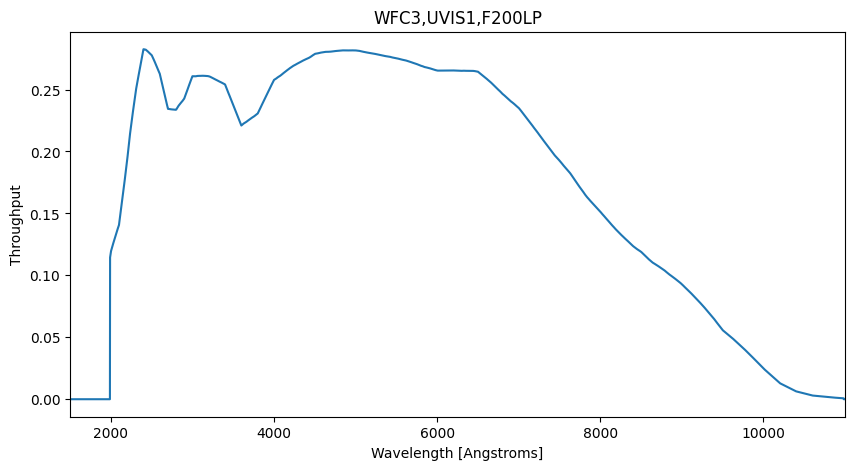

In [22]:
fig = plt.figure(figsize=(10, 5))
plt.plot(wl, tp)
plt.xlim(1500, 11000) 
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Throughput')
plt.title('WFC3,UVIS1,F200LP')

To save the curve in an ascii table, simply pass the argument `save=True`:

In [23]:
calculate_bands(bp, save=True)

(<Quantity [  500.,  1000.,  1010., ..., 20002., 30000., 30010.] Angstrom>,
 <Quantity [0., 0., 0., ..., 0., 0., 0.]>)

To save curves for all obsmodes defined in [Section 3](#inps) in the input list, we can loop through detectors and filters.

In [24]:
for det in detectors:
    for filt in filtnames:
        obsmode = f'wfc3, {det}, {filt}'
        bp = stsyn.band(obsmode)
        calculate_bands(bp, save=True)

In addition, we'll create a directory called `obsmodes_curves` and move all the saved files to that directory.

In [25]:
! mkdir obsmodes_curves
! mv wfc3*txt obsmodes_curves
! ls obsmodes_curves

mkdir: cannot create directory ‘obsmodes_curves’: File exists


'wfc3, uvis1, f200lp.txt'  'wfc3, uvis1, f438w.txt'   'wfc3, uvis1, f645n.txt'
'wfc3, uvis1, f218w.txt'   'wfc3, uvis1, f467m.txt'   'wfc3, uvis1, f656n.txt'
'wfc3, uvis1, f225w.txt'   'wfc3, uvis1, f469n.txt'   'wfc3, uvis1, f657n.txt'
'wfc3, uvis1, f275w.txt'   'wfc3, uvis1, f475w.txt'   'wfc3, uvis1, f658n.txt'
'wfc3, uvis1, f280n.txt'   'wfc3, uvis1, f475x.txt'   'wfc3, uvis1, f665n.txt'
'wfc3, uvis1, f300x.txt'   'wfc3, uvis1, f487n.txt'   'wfc3, uvis1, f673n.txt'
'wfc3, uvis1, f336w.txt'   'wfc3, uvis1, f502n.txt'   'wfc3, uvis1, f680n.txt'
'wfc3, uvis1, f343n.txt'   'wfc3, uvis1, f547m.txt'   'wfc3, uvis1, f689m.txt'
'wfc3, uvis1, f350lp.txt'  'wfc3, uvis1, f555w.txt'   'wfc3, uvis1, f763m.txt'
'wfc3, uvis1, f373n.txt'   'wfc3, uvis1, f600lp.txt'  'wfc3, uvis1, f775w.txt'
'wfc3, uvis1, f390m.txt'   'wfc3, uvis1, f606w.txt'   'wfc3, uvis1, f814w.txt'
'wfc3, uvis1, f390w.txt'   'wfc3, uvis1, f621m.txt'   'wfc3, uvis1, f845m.txt'
'wfc3, uvis1, f395n.txt'   'wfc3, uvis1, f625w.txt' 

<a id="conclusions"></a>
## 8. Conclusions

Thank you for walking through this notebook. Now using WFC3 data, you should be more familiar with:

- Calculating zeropoints and other photometric properties using `stsynphot`.
- Creating, plotting, and saving 'total system throughput' tables.

#### Congratulations, you have completed the notebook!

<a id="resources"></a>
## Additional Resources
Below are some additional resources that may be helpful. Please send any questions through the [HST Helpdesk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
    - see sections 9.5.2 for reference to this notebook
    
<a id="about"></a>
## About this Notebook

**Authors:** Varun Bajaj, Jennifer Mack; WFC3 Instrument Team

**Updated on:** 2024-03-18

<a id="cite"></a>
## Citations

If you use `numpy`, `astropy`, `synphot`, or `stsynphot` for published research, please cite the
authors. Follow these links for more information about citing the libraries below:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `synphot`](https://synphot.readthedocs.io/en/latest/)
* [Citing `stsynphot`](https://stsynphot.readthedocs.io/en/latest/index.html)

<hr>

[Top of Page](#title)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 